Coding Agent - Workflow-based approach

In [1]:
from pydantic import BaseModel, Field

class Code(BaseModel):
    """Schema for code solutions from the coding assistant"""
    prefix: str = Field(description='Description of the problem and approach')
    imports: str = Field(description='Code Block import statements')
    code: str = Field(description='Code block not including import statements')

Create LLM w/ system prompt

In [3]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama import ChatOllama

code_system_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            """You are a python coding assistant with expertise in exploratory data analysis.
            Answer the user question relevant to the dataset provided by the user.
            The user will provide a dataset path from which you can read it.
            Ensure any code you provide can be executed with all required imports and variables defined.
            Structure your answer with a description of the code solution. 
            Then list the imports. 
            And finally list the functioning code block.""",
        ),
        (
            'placeholder', '{messages}'
        ),
    ]
)

llm_model_name = 'llama3.2'
llm = ChatOllama(model=llm_model_name)
code_agent_chain = code_system_prompt | llm.with_structured_output(Code)

Defining graph state

In [4]:
from typing import List
from typing_extensions import TypedDict

class State(TypedDict):
    """
    error : Binary flag for control flow to check whether test error was tripped
    next_step: Binary flag for control flow to check whether next step in code solution is required
    messages: chat history with user questions and AI responses
    generation: code solution
    iterations: number of tries
    """
    task: str
    error: str
    next_step: str
    messages: List
    generation: str
    iterations: int
    error_iterations: int

In [7]:
# Defining the nodes
def generate(state: State):
    """
    Node to generate code solution

    Arguments:
        state (dict): The current graph state

    Returns:
        state (dict): The updated graph state

    """

    print('----- Generating Code -----')

    # Store State variables
    messages = state['messages']
    error = state['error']
    next_step = state['next_step']
    iterations = state['iterations']
    error_iterations = state['error_iterations']
    task = state['task']

    # if we've been routed back with error
    if error == 'yes':
        # error fix prompt
        messages += [
            (
                'user',
                'Now, try again. Invoke the code tool to structure the output with a prefix, imports and code block.'
            )
        ]
        error = 'no'
    else:
        messages += [
            (
                'user',
                f"""
                    The user wants to complete this task: {task}.
                    Based on what you already know, do you need to inspect the dataset and its columns and unique values in the columns first? 
                    If yes, generate python code for it.
                    If no, generate the final solution.
                    Invoke the code tool to structure the output with a prefix, imports and code block."""
            )
        ]
    code_solution = code_agent_chain.invoke(
        {'messages': messages}
    )

    if code_solution.prefix == 'end':
        next_step = 'end'
    else:
        messages += [
            (
                'assistant',
                f"{code_solution.prefix} \n Imports: {code_solution.imports} \n Code Block: {code_solution.code}",
            )
        ]
    # Increment
    iterations += 1

    return {
        'generation': code_solution,
        'messages': messages,
        'iterations': iterations,
        'error_iterations': error_iterations,
        'next_step': next_step,
        'error': error
    }

def execute_and_check_code(state: State):
    """
    Execute code and check for errors.
    
    Arguments:
        state (dict): The current Graph state.
    Returns:
        state (dict): The updated graph state.
    """

    print("----- Executing code -----")

    # storing State variables
    messages = state["messages"]
    error = state["error"]
    code_solution = state["generation"]
    iterations = state["iterations"]
    error_iterations = state["error_iterations"]
    next_step = state["next_step"]
    imports = code_solution.imports
    code_to_run = code_solution.code

    # check imports
    try:
        exec(imports)
    except Exception as e:
        print('---- Code Exceution Failed: Imports ----')
        error_message = [
            (
                'user',
                f'Your code solution failed the import test: {e}'
            )
        ]
        messages += error_message
        return {
            'generation': code_solution,
            'messages': messages,
            'iterations': iterations,
            'error_iterations': error_iterations,
            'error': 'yes'
        }

    # check execution
    try:
        exec(imports + '\n' + code_to_run)
    except Exception as e:
        print('---- Code Exceution Failed: Code Block ----')
        error_message = [
            (
                'user',
                f'Your code failed the code execution test: {e}'
            )
        ]
        messages += error_message
        return {
            'generation': code_solution,
            'messages': messages,
            'iterations': iterations,
            'error_iterations': error_iterations,
            'error': 'yes'
        }

    # No failures
    print('---- No Code Failures----')
    next_step = 'yes'
    return {
        'generation': code_solution,
        'messages': messages,
        'iterations': iterations,
        'error_iterations': error_iterations,
        'next_step': next_step
    }

def decide_to_finish(state:State):
    """
    Checks whether maximum allowed iterations are over
    """

    iterations = state['iterations']
    error_iterations = state['error_iterations']
    next_step = state['next_step']

    if iterations >= max_iters or error_iterations >= max_trys or next_step == 'end':
        print('---DECISION: FINISH---')
        return 'end'
    else:
        return 'execute_code'

In [8]:
from langgraph.graph import END, StateGraph, START

workflow_builder = StateGraph(State)

# define the nodes
workflow_builder.add_node('generate', generate) # generate solution
workflow_builder.add_node('check_code', execute_and_check_code)

# Build graph
workflow_builder.add_edge(START, 'generate')
workflow_builder.add_conditional_edges(
    'generate',
    decide_to_finish,
    {
        'end': END,
        'execute_code': 'check_code'
    }
)
workflow_builder.add_edge('check_code', 'generate')
workflow = workflow_builder.compile()

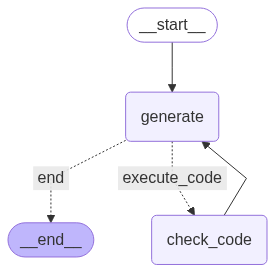

In [9]:
from IPython.display import Image, display

display(Image(workflow.get_graph().draw_mermaid_png()))